# Imports e Upload

In [2]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from datetime import datetime
import xgboost as xgb
import lightgbm as lgb

# Configuracao MLflow

In [3]:
import mlflow
import mlflow.sklearn
import os

# Configurar MLflow com caminho absoluto
notebook_dir = os.path.dirname(os.path.abspath("__file__")) if "__file__" in dir() else os.getcwd()
mlruns_path = os.path.join(notebook_dir, "mlruns")
mlflow.set_tracking_uri(f"file:{mlruns_path}")
mlflow.set_experiment("Predicao_Precos_Carros")

print("MLflow configurado!")
print(f"Tracking URI: {mlflow.get_tracking_uri()}")
experiment = mlflow.get_experiment_by_name('Predicao_Precos_Carros')
if experiment:
    print(f"Experimento ativo: {experiment.name} (ID: {experiment.experiment_id})")
else:
    print("Experimento criado: Predicao_Precos_Carros")

2025/10/01 12:10:37 INFO mlflow.tracking.fluent: Experiment with name 'Predicao_Precos_Carros' does not exist. Creating a new experiment.


MLflow configurado!
Tracking URI: file:c:\Users\natha\MachineLearningCarros\notebooks\mlruns
Experimento ativo: Predicao_Precos_Carros (ID: 261412830755867317)


In [4]:
df = pd.read_csv("../data/raw/dataset_carros_brasil.csv")

# Análise Exploratória

In [5]:
df.shape

(10000, 9)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Marca          10000 non-null  object 
 1   Modelo         10000 non-null  object 
 2   Ano            9900 non-null   float64
 3   Quilometragem  10000 non-null  object 
 4   Cor            10000 non-null  object 
 5   Cambio         10000 non-null  object 
 6   Combustivel    10000 non-null  object 
 7   Portas         10000 non-null  int64  
 8   Valor_Venda    10000 non-null  float64
dtypes: float64(2), int64(1), object(6)
memory usage: 703.3+ KB


In [7]:
display(df)

,Marca,Modelo,Ano,Quilometragem,Cor,Cambio,Combustivel,Portas,Valor_Venda
0,Ford,EcoSport,2003.0,82624,Azul,Automático,Flex,4,52604.2
1,Hyundai,HB20S,2017.0,69260,Azul,Automático,Diesel,2,63219.0
2,Jeep,Renegade,2008.0,106493,Cinza,Manual,Gasolina,2,79710.4
3,Toyota,Corolla,2018.0,53570,Prata,Automático,Flex,2,99149.0
4,Ford,Ranger,2009.0,21643,Prata,Manual,Flex,2,68913.4
...,...,...,...,...,...,...,...,...,...
9995,Ford,EcoSport,2008.0,141618,Vermelho,Automático,Flex,2,47848.4
9996,Nissan,Frontier,2019.0,141820,Branco,Manual,Gasolina,2,69586.0
9997,Fiat,Cronos,2003.0,67089,Vermelho,Manual,Flex,4,36726.2
9998,Nissan,Versa,2000.0,191101,Cinza,Manual,Flex,2,31730.8


## Removendo nulos

In [8]:
# Remover linhas com qualquer valor nulo
df_clean = df.dropna()

print("Shape original:", df.shape)
print("Shape após remoção de nulos:", df_clean.shape)

# Conferir se ainda restaram valores nulos
print("\nValores nulos por coluna:")
print(df_clean.isna().sum())

Shape original: (10000, 9)
Shape após remoção de nulos: (9900, 9)

Valores nulos por coluna:
Marca            0
Modelo           0
Ano              0
Quilometragem    0
Cor              0
Cambio           0
Combustivel      0
Portas           0
Valor_Venda      0
dtype: int64


In [9]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9900 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Marca          9900 non-null   object 
 1   Modelo         9900 non-null   object 
 2   Ano            9900 non-null   float64
 3   Quilometragem  9900 non-null   object 
 4   Cor            9900 non-null   object 
 5   Cambio         9900 non-null   object 
 6   Combustivel    9900 non-null   object 
 7   Portas         9900 non-null   int64  
 8   Valor_Venda    9900 non-null   float64
dtypes: float64(2), int64(1), object(6)
memory usage: 773.4+ KB


## Verificando as colunas categóricas

In [10]:
categorical_cols = ["Marca", "Modelo", "Cor", "Cambio", "Combustivel", "Portas", "Quilometragem"]

for col in categorical_cols:
    uniques = df_clean[col].unique()
    print(f"\n{col}")
    print(f"Total de categorias: {len(uniques)}")
    print(uniques)


Marca
Total de categorias: 10
['Ford' 'Hyundai' 'Jeep' 'Toyota' 'Nissan' 'Fiat' 'Honda' 'Chevrolet'
 'Volkswagen' 'Renault']

Modelo
Total de categorias: 32
['EcoSport' 'HB20S' 'Renegade' 'Corolla' 'Ranger' 'Frontier' 'Toro'
 'Hilux' 'HB20' 'Argo' 'Civic' 'Onix Plus' 'HR-V' 'Gol' 'Kicks' 'Sandero'
 'Virtus' 'Versa' 'Yaris' 'Mobi' 'Ka' 'Kwid' 'Tracker' 'Creta' 'Cronos'
 'T-Cross' 'Compass' 'S10' 'Duster' 'Onix' 'Polo' 'Fit']

Cor
Total de categorias: 6
['Azul' 'Cinza' 'Prata' 'Preto' 'Vermelho' 'Branco']

Cambio
Total de categorias: 2
['Automático' 'Manual']

Combustivel
Total de categorias: 3
['Flex' 'Diesel' 'Gasolina']

Portas
Total de categorias: 2
[4 2]

Quilometragem
Total de categorias: 9559
['82624' '69260' '106493' ... '67089' '191101' '156313']


## Limpando a Quilometragem

In [11]:
# Contagem dos valores únicos
print(df_clean["Quilometragem"].value_counts().head(20))
print("\nTotal de valores distintos:", df_clean["Quilometragem"].nunique())

# Mostrar exemplos que não são numéricos
mask_non_numeric = df_clean["Quilometragem"].str.contains(r"[^\d\.]", regex=True, na=False)
print("\nExemplos de valores com texto dentro:")
print(df_clean.loc[mask_non_numeric, "Quilometragem"].unique()[:20])

Quilometragem
erro_medicao    99
166373           3
118222           3
124790           3
97491            3
95381            2
81254            2
125200           2
189928           2
73497            2
79942            2
44420            2
113417           2
56436            2
159701           2
142953           2
3801             2
76323            2
45832            2
51356            2
Name: count, dtype: int64

Total de valores distintos: 9559

Exemplos de valores com texto dentro:
['erro_medicao']


In [12]:
df_clean = df_clean[df_clean["Quilometragem"] != "erro_medicao"].copy()
print("Shape após remoção:", df_clean.shape)

Shape após remoção: (9801, 9)


In [13]:
df_clean.describe()

,Ano,Portas,Valor_Venda
count,9801.000000,9801.000000,9.801000e+03
mean,2011.509438,3.009693,8.320082e+04
std,6.897880,1.000004,1.672646e+05
min,2000.000000,2.000000,1.000000e+04
25%,2006.000000,2.000000,4.444760e+04
50%,2012.000000,4.000000,5.893580e+04
75%,2017.000000,4.000000,7.484280e+04
max,2023.000000,4.000000,1.241962e+06


## Arrumando os tipos

In [14]:
df_clean["Ano"] = df_clean["Ano"].astype(int)
df_clean["Quilometragem"] = df_clean["Quilometragem"].astype(float)
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9801 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Marca          9801 non-null   object 
 1   Modelo         9801 non-null   object 
 2   Ano            9801 non-null   int64  
 3   Quilometragem  9801 non-null   float64
 4   Cor            9801 non-null   object 
 5   Cambio         9801 non-null   object 
 6   Combustivel    9801 non-null   object 
 7   Portas         9801 non-null   int64  
 8   Valor_Venda    9801 non-null   float64
dtypes: float64(2), int64(2), object(5)
memory usage: 765.7+ KB


## Verificando Outliers (Ainda não apaguei)

In [15]:
# Função para contar outliers com base no IQR
def contar_outliers(grupo, coluna="Valor_Venda"):
    Q1 = grupo[coluna].quantile(0.25)
    Q3 = grupo[coluna].quantile(0.75)
    IQR = Q3 - Q1
    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR
    outliers = grupo[(grupo[coluna] < limite_inferior) | (grupo[coluna] > limite_superior)]
    return len(outliers)

# Calcular outliers por marca
outliers_por_marca = df_clean.groupby("Marca").apply(contar_outliers).reset_index(name="Qtd_Outliers")

# Ordenar do maior para o menor
outliers_por_marca = outliers_por_marca.sort_values(by="Qtd_Outliers", ascending=False)

outliers_por_marca.head(50)

C:\Users\natha\AppData\Local\Temp\ipykernel_23316\1224703819.py:12: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  outliers_por_marca = df_clean.groupby("Marca").apply(contar_outliers).reset_index(name="Qtd_Outliers")


,Marca,Qtd_Outliers
1,Fiat,28
0,Chevrolet,24
6,Nissan,24
7,Renault,23
9,Volkswagen,20
2,Ford,17
8,Toyota,17
4,Hyundai,16
5,Jeep,15
3,Honda,14


In [16]:
# Calcular outliers por modelo
outliers_por_modelo = df_clean.groupby("Modelo").apply(contar_outliers).reset_index(name="Qtd_Outliers")

# Ordenar do maior para o menor
outliers_por_modelo = outliers_por_modelo.sort_values(by="Qtd_Outliers", ascending=False)

outliers_por_modelo.head(50)

C:\Users\natha\AppData\Local\Temp\ipykernel_23316\2748338716.py:2: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  outliers_por_modelo = df_clean.groupby("Modelo").apply(contar_outliers).reset_index(name="Qtd_Outliers")


,Modelo,Qtd_Outliers
5,Cronos,12
9,Frontier,12
23,Renegade,10
17,Kwid,10
18,Mobi,9
19,Onix,8
15,Ka,8
20,Onix Plus,8
24,S10,7
31,Yaris,7


<Figure size 1200x600 with 0 Axes>

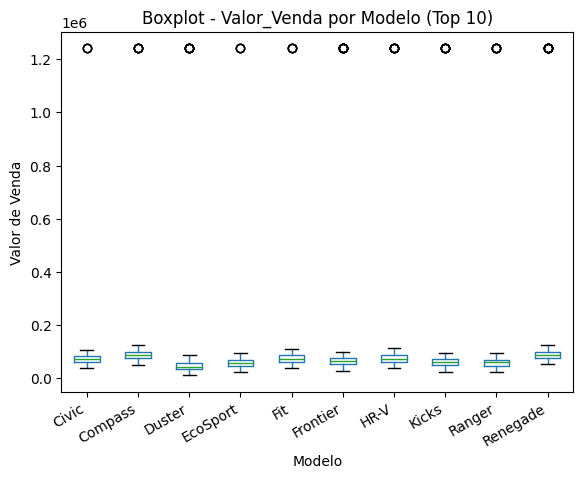

In [17]:
# Selecionar os 10 modelos mais frequentes
top_modelos = df_clean["Modelo"].value_counts().head(10).index
df_clean_top = df_clean[df_clean["Modelo"].isin(top_modelos)]

plt.figure(figsize=(12,6))
df_clean_top.boxplot(column="Valor_Venda", by="Modelo", showfliers=True, grid=False)
plt.title("Boxplot - Valor_Venda por Modelo (Top 10)")
plt.suptitle("")
plt.xlabel("Modelo")
plt.ylabel("Valor de Venda")
plt.xticks(rotation=30, ha="right")
plt.show()


# Removendo outliers por marca

In [18]:
df_clean = df.dropna()
df_clean = df_clean[df_clean["Quilometragem"] != "erro_medicao"].copy()
df_clean["Ano"] = df_clean["Ano"].astype(int)
df_clean["Quilometragem"] = df_clean["Quilometragem"].astype(float)


# Função que calcula os limites IQR e filtra o grupo
def remover_outliers_grupo(grupo, coluna='Valor_Venda'):
    Q1 = grupo[coluna].quantile(0.25)
    Q3 = grupo[coluna].quantile(0.75)
    IQR = Q3 - Q1
    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR

    # Retorna o grupo filtrado, mantendo apenas os valores dentro dos limites
    return grupo[(grupo[coluna] >= limite_inferior) & (grupo[coluna] <= limite_superior)]

# Agrupar o DataFrame por 'Marca'
# Aplicar a função a cada grupo
# Resetar o índice para juntar os grupos de volta em um único DataFrame
print(f"Shape antes da remoção de outliers por marca: {df_clean.shape}")

df_clean = df_clean.groupby('Marca').apply(remover_outliers_grupo).reset_index(drop=True)

print(f"Shape depois da remoção de outliers por marca: {df_clean.shape}")

df_clean.groupby('Marca')['Valor_Venda'].describe()

Shape antes da remoção de outliers por marca: (9801, 9)
Shape depois da remoção de outliers por marca: (9603, 9)


C:\Users\natha\AppData\Local\Temp\ipykernel_23316\1305782487.py:23: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_clean = df_clean.groupby('Marca').apply(remover_outliers_grupo).reset_index(drop=True)


,count,mean,std,min,25%,50%,75%,max
Marca,,,,,,,,
Chevrolet,948.0,48945.603797,16163.088247,10000.0,37261.15,48889.7,60768.65,88726.4
Fiat,947.0,45505.569588,15696.905728,10000.0,34254.30,45283.2,56588.20,84047.6
Ford,983.0,57247.147508,16012.054296,19524.2,45465.90,57526.6,69105.20,94471.6
Honda,989.0,72237.992315,16189.960476,36135.2,60135.40,72560.6,84195.00,111464.0
Hyundai,924.0,52751.791558,14525.435808,16951.0,43133.85,52743.0,62807.20,91396.2
Jeep,938.0,87053.177825,15832.594182,48862.6,75777.25,86984.6,97842.45,124196.2
Nissan,994.0,62089.731992,15931.669156,21502.6,50250.65,62408.8,73763.10,104107.6
Renault,949.0,44502.650580,15731.629170,10000.0,33453.20,43749.8,56012.80,85909.6
Toyota,920.0,76858.490217,15876.194927,36034.6,65603.20,76636.3,88092.75,118311.4


# Verificando duplicatas

In [19]:
print(f"Linhas duplicadas: {df_clean.duplicated().sum()}")
df_clean.drop_duplicates(inplace=True)

Linhas duplicadas: 0


# Criando features

In [20]:
from datetime import datetime

ano_atual = datetime.now().year
df_clean['Idade_Veiculo'] = ano_atual - df_clean['Ano']

df_clean.drop('Ano', axis=1, inplace=True)

In [21]:
# Adicionamos +1 na idade para evitar divisão por zero caso o carro seja do ano corrente
df_clean['Km_por_Ano'] = df_clean['Quilometragem'] / (df_clean['Idade_Veiculo'] + 1)

# Salvando dados processados

In [22]:
import os

# Criar diretório se não existir
os.makedirs('../data/processed', exist_ok=True)

# Salvar dados limpos em CSV
df_clean.to_csv('../data/processed/dataset_limpo.csv', index=False)

# Salvar também em pickle para preservar tipos
df_clean.to_pickle('../data/processed/dataset_limpo.pkl')

print(f"Dados processados salvos em data/processed/")
print(f"Total de registros: {len(df_clean)}")
print(f"Colunas: {list(df_clean.columns)}")

Dados processados salvos em data/processed/
Total de registros: 9603
Colunas: ['Marca', 'Modelo', 'Quilometragem', 'Cor', 'Cambio', 'Combustivel', 'Portas', 'Valor_Venda', 'Idade_Veiculo', 'Km_por_Ano']


In [23]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb
import lightgbm as lgb

# Split ANTES de qualquer transformação
X = df_clean.drop('Valor_Venda', axis=1)
y = df_clean['Valor_Venda']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)

# Colunas categóricas e numéricas
cat_cols = ['Marca', 'Modelo', 'Cor', 'Cambio', 'Combustivel']
num_cols = [c for c in X.columns if c not in cat_cols]

# Preprocessador sem vazamento 
try:
    ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
except TypeError:
    ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)

preprocess = ColumnTransformer(
    transformers=[
        ('cat', ohe, cat_cols),
        ('num', StandardScaler(), num_cols)  # scaling ajuda Linear/Ridge/Lasso; inofensivo p/ árvores/boosting
    ],
    remainder='drop'
)

# Modelos a comparar
modelos = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(random_state=42),
    "Lasso Regression": Lasso(random_state=42),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(random_state=42, n_jobs=-1),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    "XGBoost": xgb.XGBRegressor(random_state=42, n_jobs=-1),
    "LightGBM": lgb.LGBMRegressor(random_state=42, n_jobs=-1)
}

# Treino/Avaliação com Pipeline
resultados = []

print("Iniciando treinamento e avaliação dos modelos (sem vazamento)...")
for nome, modelo in modelos.items():
    print(f"Treinando {nome}...")

    pipe = Pipeline(steps=[
        ('preprocess', preprocess),
        ('model', modelo)
    ])

    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_test)

    mae = mean_absolute_error(y_test, preds)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    r2 = r2_score(y_test, preds)

    resultados.append({
        "Modelo": nome,
        "MAE (R$)": mae,
        "RMSE (R$)": rmse,
        "R²": r2
    })

# Comparação
df_resultados = pd.DataFrame(resultados).sort_values(by='R²', ascending=False)

print("\nResultados Finais da Comparação dos Modelos (sem vazamento)")
df_resultados.round(4)


Iniciando treinamento e avaliação dos modelos (sem vazamento)...
Treinando Linear Regression...
Treinando Ridge Regression...
Treinando Lasso Regression...
Treinando Decision Tree...
Treinando Random Forest...
Treinando Gradient Boosting...
Treinando XGBoost...
Treinando LightGBM...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000217 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 644
[LightGBM] [Info] Number of data points in the train set: 7682, number of used features: 57
[LightGBM] [Info] Start training from score 59439.326550

Resultados Finais da Comparação dos Modelos (sem vazamento)


c:\Users\natha\MachineLearningCarros\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


,Modelo,MAE (R$),RMSE (R$),R²
2,Lasso Regression,2527.5423,2917.9345,0.9803
1,Ridge Regression,2528.4153,2919.3763,0.9803
0,Linear Regression,2528.4533,2919.5109,0.9803
7,LightGBM,2620.1827,3096.6599,0.9778
5,Gradient Boosting,2668.5194,3179.8598,0.9766
4,Random Forest,2756.9417,3303.7193,0.9748
6,XGBoost,2824.8673,3381.2427,0.9736
3,Decision Tree,3767.2883,4626.3144,0.9506


# Teste hiperparametrizando

In [24]:
import numpy as np
import pandas as pd
from datetime import datetime
import warnings
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb
import lightgbm as lgb
import mlflow
import mlflow.sklearn

warnings.filterwarnings("ignore")

# Split ANTES de qualquer transformação
X = df_clean.drop('Valor_Venda', axis=1)
y = df_clean['Valor_Venda']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)

# Colunas categóricas e numéricas
cat_cols = ['Marca', 'Modelo', 'Cor', 'Cambio', 'Combustivel']
num_cols = [c for c in X.columns if c not in cat_cols]

# Preprocessador
try:
    ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
except TypeError:
    ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)

preprocess = ColumnTransformer(
    transformers=[
        ('cat', ohe, cat_cols),
        ('num', StandardScaler(), num_cols)  # ajuda lineares; ok para árvores/boosting
    ],
    remainder='drop'
)

# Modelos base
modelos = {
    "Ridge": Ridge(),
    "Lasso": Lasso(),
    "Random Forest": RandomForestRegressor(random_state=42, n_jobs=-1),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    "XGBoost": xgb.XGBRegressor(random_state=42, n_jobs=-1, tree_method="hist"),
    "LightGBM": lgb.LGBMRegressor(random_state=42, n_jobs=-1, verbose=-1)
}

param_grids = {
    "Ridge": {
        'model__alpha': [0.1, 1.0, 10.0, 100.0]
    },
    "Lasso": {
        'model__alpha': [0.1, 1.0, 10.0, 100.0]
    },
    "Random Forest": {
        'model__n_estimators': [200, 400],
        'model__max_depth': [10, 20, None],
        'model__min_samples_split': [2, 5]
    },
    "Gradient Boosting": {
        'model__n_estimators': [200, 400],
        'model__learning_rate': [0.05, 0.1],
        'model__max_depth': [3, 5]
    },
    "XGBoost": {
        'model__n_estimators': [300, 600],
        'model__learning_rate': [0.05, 0.1],
        'model__max_depth': [3, 5],
        'model__subsample': [0.8, 1.0],
        'model__colsample_bytree': [0.8, 1.0]
    },
    "LightGBM": {
        'model__n_estimators': [300, 600],
        'model__learning_rate': [0.05, 0.1],
        'model__num_leaves': [31, 63],
        'model__min_child_samples': [20, 40]
    }
}

# CV e Tracking
cv = KFold(n_splits=5, shuffle=True, random_state=42)
resultados_otimizados = []

print("Iniciando busca de hiperparâmetros com MLflow tracking...")

for nome, modelo in modelos.items():
    print(f"Otimizando {nome}...")

    pipe = Pipeline(steps=[
        ('preprocess', preprocess),
        ('model', modelo)
    ])

    with mlflow.start_run(run_name=f"{nome}_GridSearch"):
        grid = GridSearchCV(
            estimator=pipe,
            param_grid=param_grids[nome],
            cv=cv,
            scoring='r2',
            n_jobs=-1,
            refit=True,
            error_score='raise'  
        )
        grid.fit(X_train, y_train)
        best_pipe = grid.best_estimator_

        # Predição no hold-out
        preds = best_pipe.predict(X_test)

        # Métricas
        mae = mean_absolute_error(y_test, preds)
        rmse = np.sqrt(mean_squared_error(y_test, preds))
        r2 = r2_score(y_test, preds)

        # Logging no MLflow
        # Parâmetros do Grid
        mlflow.log_params({k.replace('model__', ''): v for k, v in grid.best_params_.items()})
        mlflow.log_param("modelo_tipo", nome)
        mlflow.log_param("cv_folds", cv.get_n_splits())
        mlflow.log_param("test_size", 0.2)
        mlflow.log_param("random_state", 42)

        # Métricas
        mlflow.log_metric("mae", mae)
        mlflow.log_metric("rmse", rmse)
        mlflow.log_metric("r2_score", r2)

        # Info de features após o fit
        # Transforma X_train só com o preprocess para inspecionar número de features geradas
        Xt_train = best_pipe.named_steps['preprocess'].fit_transform(X_train, y_train)
        mlflow.log_param("n_features_after_preprocess", Xt_train.shape[1])
        mlflow.log_param("n_train_samples", X_train.shape[0])
        mlflow.log_param("n_test_samples", X_test.shape[0])

        # Modelo completo
        mlflow.sklearn.log_model(
            sk_model=best_pipe,
            artifact_path=f"model_{nome.replace(' ', '_')}"
        )

        # Tags
        if nome in ["XGBoost", "LightGBM"]:
            mlflow.set_tag("framework", nome)
        else:
            mlflow.set_tag("framework", "scikit-learn")

        mlflow.set_tag("model_family", "linear" if nome in ["Ridge", "Lasso"] else "tree-based")

        resultados_otimizados.append({
            "Modelo": nome,
            "MAE (R$)": mae,
            "RMSE (R$)": rmse,
            "R²": r2,
            "Melhores Parâmetros": {k.replace('model__', ''): v for k, v in grid.best_params_.items()},
            "MLflow Run ID": mlflow.active_run().info.run_id
        })

        print(f"  Registrado no MLflow (Run ID: {mlflow.active_run().info.run_id[:8]}...)")

# Comparação final
df_resultados_otimizados = (
    pd.DataFrame(resultados_otimizados)
      .sort_values(by='R²', ascending=False)
)

print("\nResultados Finais dos Modelos Otimizados")
print("Todos os experimentos registrados no MLflow!")
pd.set_option('display.max_colwidth', None)
df_resultados_otimizados.round(4)


Iniciando busca de hiperparâmetros com MLflow tracking...
Otimizando Ridge...


2025/10/01 12:23:01 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/01 12:23:08 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


  Registrado no MLflow (Run ID: afbeba18...)
Otimizando Lasso...


2025/10/01 12:23:09 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/01 12:23:13 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


  Registrado no MLflow (Run ID: b17dc6c1...)
Otimizando Random Forest...


2025/10/01 12:24:49 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/01 12:24:52 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


  Registrado no MLflow (Run ID: 482e800c...)
Otimizando Gradient Boosting...


2025/10/01 12:25:32 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/01 12:25:35 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


  Registrado no MLflow (Run ID: 7775432f...)
Otimizando XGBoost...


2025/10/01 12:25:51 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/01 12:25:54 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


  Registrado no MLflow (Run ID: 6988d6a9...)
Otimizando LightGBM...


2025/10/01 12:26:44 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/01 12:26:47 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


  Registrado no MLflow (Run ID: bc58ba2c...)

Resultados Finais dos Modelos Otimizados
Todos os experimentos registrados no MLflow!


,Modelo,MAE (R$),RMSE (R$),R²,Melhores Parâmetros,MLflow Run ID
1,Lasso,2521.0772,2911.3189,0.9804,{'alpha': 10.0},b17dc6c13ed4454d98b10ec1a9dd6e4f
0,Ridge,2528.4153,2919.3763,0.9803,{'alpha': 1.0},afbeba18037d44d38e1f3336d2ebfff7
4,XGBoost,2581.5844,3012.5692,0.9790,"{'colsample_bytree': 1.0, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 600, 'subsample': 0.8}",6988d6a998c1450584844a294945baba
3,Gradient Boosting,2609.8313,3051.1304,0.9785,"{'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 400}",7775432fc28346cfb9224a8d0f88cb36
5,LightGBM,2589.4276,3059.2159,0.9784,"{'learning_rate': 0.05, 'min_child_samples': 40, 'n_estimators': 300, 'num_leaves': 31}",bc58ba2ce8a64b75ad82034ea2ac6fb5
2,Random Forest,2725.1578,3264.0836,0.9754,"{'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 400}",482e800c69e24127baea5a9c956e626e


In [25]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.linear_model import Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import numpy as np
import pandas as pd
import warnings, os
import xgboost as xgb
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings('ignore')
sns.set(style='whitegrid')
os.makedirs('../reports/figures', exist_ok=True)

# Split sem vazamento
X = df_clean.drop('Valor_Venda', axis=1)
y = df_clean['Valor_Venda']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)

# Colunas
cat_cols = ['Marca', 'Modelo', 'Cor', 'Cambio', 'Combustivel']
num_cols = [c for c in X.columns if c not in cat_cols]

# Preprocessador
try:
    ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
except TypeError:
    ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)

preprocess = ColumnTransformer(
    transformers=[
        ('cat', ohe, cat_cols),
        ('num', StandardScaler(), num_cols),
    ],
    remainder='drop'
)

# Modelos e grids
modelos = {
    "Ridge": Ridge(),
    "Lasso": Lasso(),
    "Random Forest": RandomForestRegressor(random_state=42, n_jobs=-1),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    "XGBoost": xgb.XGBRegressor(random_state=42, n_jobs=-1, tree_method="hist"),
    "LightGBM": lgb.LGBMRegressor(random_state=42, n_jobs=-1)
}
param_grids = {
    "Ridge": {'model__alpha': [0.1, 1.0, 10.0]},
    "Lasso": {'model__alpha': [0.1, 1.0, 10.0]},
    "Random Forest": {'model__n_estimators': [100, 200], 'model__max_depth': [10, 20]},
    "Gradient Boosting": {'model__n_estimators': [100, 200], 'model__learning_rate': [0.1], 'model__max_depth': [3]},
    "XGBoost": {'model__n_estimators': [100, 200], 'model__learning_rate': [0.1], 'model__max_depth': [3]},
    "LightGBM": {'model__n_estimators': [100, 200], 'model__learning_rate': [0.1], 'model__num_leaves': [31]}
}

# Função: nomes das features transformadas
def get_feature_names_from_column_transformer(ct: ColumnTransformer) -> list:
    """
    Retorna a lista de nomes de colunas após o ColumnTransformer.
    Suporta OneHotEncoder e passthrough de numéricas com StandardScaler.
    """
    feature_names = []

    for name, transformer, cols in ct.transformers_:
        if transformer == 'drop':
            continue
        if transformer == 'passthrough':
            # quando passthrough, as cols já são strings
            feature_names.extend(cols)
            continue

        # Pipelines internas? Pegamos o último step se necessário
        if hasattr(transformer, 'named_steps'):
            # assume último step realizador da transformação
            last_step = list(transformer.named_steps.values())[-1]
        else:
            last_step = transformer

        if hasattr(last_step, 'get_feature_names_out'):
            try:
                # Para OneHotEncoder, retorna nomes com prefixos
                names = last_step.get_feature_names_out(cols)
            except TypeError:
                # versões mais antigas aceitam sem 'cols'
                names = last_step.get_feature_names_out()
            feature_names.extend(names)
        else:
            # fallback: usa nomes originais das cols
            if isinstance(cols, (list, tuple, np.ndarray)):
                feature_names.extend(cols)
            else:
                feature_names.append(cols)

    return list(feature_names)


# Treino, avaliação e plotagem
print("Iniciando busca de hiperparâmetros e geração de gráficos (sem vazamento)...")

for nome, modelo in modelos.items():
    print(f"Otimizando e analisando {nome}...")

    pipe = Pipeline(steps=[
        ('preprocess', preprocess),
        ('model', modelo)
    ])

    grid = GridSearchCV(
        estimator=pipe,
        param_grid=param_grids[nome],
        cv=3, scoring='r2', n_jobs=-1, refit=True
    )
    grid.fit(X_train, y_train)
    best_pipe = grid.best_estimator_
    best_model = best_pipe.named_steps['model']
    best_pre = best_pipe.named_steps['preprocess']

    # Métricas no hold-out
    preds = best_pipe.predict(X_test)
    mae = mean_absolute_error(y_test, preds)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    r2 = r2_score(y_test, preds)
    print(f"  R²={r2:.4f} | MAE={mae:.2f} | RMSE={rmse:.2f}")

    # Importância das features 
    feature_names = get_feature_names_from_column_transformer(best_pre)

    # Importâncias/coeficientes com mesmo comprimento do vetor transformado
    if hasattr(best_model, 'feature_importances_'):
        importances = best_model.feature_importances_
    elif hasattr(best_model, 'coef_'):
        coef = best_model.coef_
        importances = np.abs(coef) if coef.ndim == 1 else np.abs(coef).mean(axis=0)
    else:
        # Se o modelo não oferece importância/coef, pule
        print(f"  {nome}: modelo sem atributo de importância/coeficiente. Pulando plot...")
        continue

    # Segurança: alinhar tamanhos
    if len(importances) != len(feature_names):
        m = min(len(importances), len(feature_names))
        importances = np.array(importances)[:m]
        feature_names = feature_names[:m]

    fi_df = (
        pd.DataFrame({'Feature': feature_names, 'Importance': importances})
        .sort_values('Importance', ascending=False)
        .head(20)
    )

    # Plot
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=fi_df)
    plt.title(f'Top 20 Features Mais Importantes - {nome}', fontsize=16)
    plt.xlabel('Importância', fontsize=12)
    plt.ylabel('Feature', fontsize=12)
    plt.tight_layout()
    plt.savefig(f'../reports/figures/importancia_features_{nome.replace(" ", "_")}.png',
                dpi=300, bbox_inches='tight')
    plt.clf()

print("\nGráficos salvos em reports/figures/")


Iniciando busca de hiperparâmetros e geração de gráficos (sem vazamento)...
Otimizando e analisando Ridge...
  R²=0.9803 | MAE=2528.45 | RMSE=2919.49
Otimizando e analisando Lasso...
  R²=0.9804 | MAE=2521.08 | RMSE=2911.32
Otimizando e analisando Random Forest...
  R²=0.9751 | MAE=2742.58 | RMSE=3285.20
Otimizando e analisando Gradient Boosting...
  R²=0.9783 | MAE=2606.54 | RMSE=3067.59
Otimizando e analisando XGBoost...
  R²=0.9783 | MAE=2608.26 | RMSE=3062.56
Otimizando e analisando LightGBM...
  R²=0.9778 | MAE=2620.18 | RMSE=3096.66

Gráficos salvos em reports/figures/


<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

# Salvando Metricas dos Modelos

In [26]:
import os
import json

# Criar diretório se não existir
os.makedirs('../reports/metrics', exist_ok=True)

# Salvar métricas em CSV
df_resultados_otimizados.to_csv('../reports/metrics/resultados_modelos.csv', index=False)

# Salvar métricas em JSON (mais estruturado)
df_resultados_otimizados.to_json('../reports/metrics/resultados_modelos.json', orient='records', indent=2)

print("Metricas salvas em reports/metrics/")
print(f"\nResumo:")
print(f"- Melhor modelo: {df_resultados_otimizados.iloc[0]['Modelo']}")
print(f"- R² Score: {df_resultados_otimizados.iloc[0]['R²']:.4f}")
print(f"- MAE: R$ {df_resultados_otimizados.iloc[0]['MAE (R$)']:.2f}")
print(f"- RMSE: R$ {df_resultados_otimizados.iloc[0]['RMSE (R$)']:.2f}")

Metricas salvas em reports/metrics/

Resumo:
- Melhor modelo: Lasso
- R² Score: 0.9804
- MAE: R$ 2521.08
- RMSE: R$ 2911.32


# Salvando Modelo Campeao

In [27]:
import os
import joblib
from sklearn.linear_model import Lasso
import mlflow
import mlflow.sklearn

# Criar diretorio se nao existir
os.makedirs('../models/trained_models', exist_ok=True)

# Treinar o modelo campeao (Lasso) com os melhores parametros
modelo_campeao = Lasso(alpha=1.0)
modelo_campeao.fit(X_train, y_train)

# Registrar modelo campeão no MLflow Model Registry
with mlflow.start_run(run_name="Modelo_Campeao_Lasso"):
    
    # Métricas finais
    previsoes_final = modelo_campeao.predict(X_test)
    mae_final = mean_absolute_error(y_test, previsoes_final)
    rmse_final = np.sqrt(mean_squared_error(y_test, previsoes_final))
    r2_final = r2_score(y_test, previsoes_final)
    
    # Logging
    mlflow.log_param("alpha", 1.0)
    mlflow.log_param("modelo", "Lasso")
    mlflow.log_metric("mae", mae_final)
    mlflow.log_metric("rmse", rmse_final)
    mlflow.log_metric("r2_score", r2_final)
    
    # Registrar modelo no MLflow
    mlflow.sklearn.log_model(
        modelo_campeao, 
        "modelo_campeao",
        registered_model_name="PredicaoCarros_Lasso_Campeao"
    )
    
    # Salvar artefatos adicionais
    mlflow.log_artifact('../reports/metrics/resultados_modelos.json')
    
    # Tags
    mlflow.set_tag("status", "producao")
    mlflow.set_tag("versao", "1.0")
    mlflow.set_tag("framework", "scikit-learn")
    
    run_id = mlflow.active_run().info.run_id
    print(f"Modelo campeao registrado no MLflow (Run ID: {run_id[:8]}...)")

# Salvar localmente também (backup)
joblib.dump(modelo_campeao, '../models/trained_models/lasso_modelo_campeao.pkl')

feature_info = {
    'features': list(X_train.columns),
    'n_features': len(X_train.columns),
    'modelo': 'Lasso',
    'parametros': {'alpha': 1.0},
    'mlflow_registered': True,
    'model_registry_name': 'PredicaoCarros_Lasso_Campeao'
}

import json
with open('../models/trained_models/feature_info.json', 'w') as f:
    json.dump(feature_info, f, indent=2)

print("\nModelo campeao salvo!")
print(f"  Local: models/trained_models/lasso_modelo_campeao.pkl")
print(f"  MLflow Model Registry: PredicaoCarros_Lasso_Campeao")
print(f"  Metricas: R²={r2_final:.4f}, MAE=R${mae_final:.2f}, RMSE=R${rmse_final:.2f}")

ValueError: could not convert string to float: 'Toyota'

In [28]:
import os, json
import numpy as np
import pandas as pd
import joblib
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import mlflow
import mlflow.sklearn

cat_cols = ['Marca', 'Modelo', 'Cor', 'Cambio', 'Combustivel']
num_cols = [c for c in X_train.columns if c not in cat_cols]

# OneHotEncoder SEM vazamento 
try:
    ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
except TypeError:
    ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)

ohe.fit(X_train[cat_cols])

# Transformar train e test
Xtr_cat = ohe.transform(X_train[cat_cols])
Xte_cat = ohe.transform(X_test[cat_cols])

# Numéricas
Xtr_num = X_train[num_cols].to_numpy(dtype=float)
Xte_num = X_test[num_cols].to_numpy(dtype=float)

# Concatenar na MESMA ORDEM que vamos salvar em feature_info.json
Xtr = np.hstack([Xtr_num, Xtr_cat])
Xte = np.hstack([Xte_num, Xte_cat])

# Construir a lista de nomes das features (numéricas + OHE)
try:
    ohe_names = ohe.get_feature_names_out(cat_cols)
except TypeError:
    # fallback para versões antigas:
    ohe_names = ohe.get_feature_names_out()

feature_names = list(num_cols) + list(ohe_names)

# Treinar o modelo campeão (Lasso)
from sklearn.linear_model import Lasso
modelo_campeao = Lasso(alpha=1.0, random_state=42)
modelo_campeao.fit(Xtr, y_train)

# Avaliar no hold-out
previsoes_final = modelo_campeao.predict(Xte)
mae_final = mean_absolute_error(y_test, previsoes_final)
rmse_final = np.sqrt(mean_squared_error(y_test, previsoes_final))
r2_final = r2_score(y_test, previsoes_final)

# Logging no MLflow
with mlflow.start_run(run_name="Modelo_Campeao_Lasso"):
    mlflow.log_param("modelo", "Lasso")
    mlflow.log_param("alpha", 1.0)
    mlflow.log_param("n_features", len(feature_names))
    mlflow.log_metric("mae", mae_final)
    mlflow.log_metric("rmse", rmse_final)
    mlflow.log_metric("r2_score", r2_final)

    os.makedirs("../models/trained_models", exist_ok=True)
    joblib.dump(ohe, "../models/trained_models/onehot_encoder.pkl")
    mlflow.log_artifact("../models/trained_models/onehot_encoder.pkl")

    # Logar o modelo 
    mlflow.sklearn.log_model(modelo_campeao, "modelo_campeao",
                             registered_model_name="PredicaoCarros_Lasso_Campeao")

    print(f"Modelo campeão registrado no MLflow | R²={r2_final:.4f} MAE={mae_final:.2f} RMSE={rmse_final:.2f}")

# Salvar localmente o modelo e o feature_info.json esperado pelo backend
joblib.dump(modelo_campeao, "../models/trained_models/lasso_modelo_campeao.pkl")

feature_info = {
    "features": feature_names,          
    "n_features": len(feature_names),
    "modelo": "Lasso",
    "parametros": {"alpha": 1.0},
    "mlflow_registered": True,
    "model_registry_name": "PredicaoCarros_Lasso_Campeao"
}

with open("../models/trained_models/feature_info.json", "w", encoding="utf-8") as f:
    json.dump(feature_info, f, ensure_ascii=False, indent=2)

print("\nModelo campeão salvo!")
print(f"  Local: models/trained_models/lasso_modelo_campeao.pkl")
print(f"  Métricas: R²={r2_final:.4f}, MAE=R${mae_final:.2f}, RMSE=R${rmse_final:.2f}")


2025/10/01 12:37:44 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/01 12:37:47 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Modelo campeão registrado no MLflow | R²=0.9803 MAE=2527.54 RMSE=2917.92

Modelo campeão salvo!
  Local: models/trained_models/lasso_modelo_campeao.pkl
  Métricas: R²=0.9803, MAE=R$2527.54, RMSE=R$2917.92


Successfully registered model 'PredicaoCarros_Lasso_Campeao'.
Created version '1' of model 'PredicaoCarros_Lasso_Campeao'.


# Visualizando Experimentos no MLflow

Para visualizar todos os experimentos registrados, execute em um terminal:

```bash
cd notebooks
mlflow ui --port 5000
```

Depois acesse: http://localhost:5000

## O que voce vera:
- **Experiments**: Comparacao de todos os 6 modelos treinados
- **Parametros**: Hiperparametros de cada modelo
- **Metricas**: MAE, RMSE, R² de cada experimento
- **Artifacts**: Modelos salvos e arquivos de metricas
- **Model Registry**: Modelo campeao registrado para producao

## Modelo Registrado:
- **Nome**: PredicaoCarros_Lasso_Campeao
- **Versao**: 1.0
- **Status**: Producao

# Testando MLflow - Visualizando Experimentos

Vamos verificar se todos os experimentos foram registrados corretamente:

In [29]:
import mlflow
import pandas as pd

# Buscar todos os experimentos
experimentos = mlflow.search_experiments()
print("Experimentos disponiveis:")
for exp in experimentos:
    print(f"  - {exp.name} (ID: {exp.experiment_id})")

# Buscar todos os runs do experimento principal
runs = mlflow.search_runs(experiment_names=["Predicao_Precos_Carros"])

print(f"\nTotal de runs: {len(runs)}")
print("\nResumo dos experimentos (ordenado por R² Score):")

# Selecionar colunas relevantes
colunas_importantes = [
    'tags.mlflow.runName',
    'metrics.r2_score', 
    'metrics.mae',
    'metrics.rmse',
    'params.modelo_tipo',
    'start_time'
]

# Filtrar apenas as colunas que existem
colunas_existentes = [col for col in colunas_importantes if col in runs.columns]

# Mostrar resultados
runs_resumo = runs[colunas_existentes].sort_values('metrics.r2_score', ascending=False)
runs_resumo.rename(columns={
    'tags.mlflow.runName': 'Nome do Run',
    'metrics.r2_score': 'R² Score',
    'metrics.mae': 'MAE',
    'metrics.rmse': 'RMSE',
    'params.modelo_tipo': 'Modelo'
}, inplace=True)

display(runs_resumo)

Experimentos disponiveis:
  - Predicao_Precos_Carros (ID: 261412830755867317)
  - Default (ID: 0)

Total de runs: 7

Resumo dos experimentos (ordenado por R² Score):


,Nome do Run,R² Score,MAE,RMSE,Modelo,start_time
5,Lasso_GridSearch,0.980421,2521.077169,2911.318854,Lasso,2025-10-01 15:23:08.472000+00:00
0,Modelo_Campeao_Lasso,0.980332,2527.536627,2917.916788,None,2025-10-01 15:37:44.192000+00:00
6,Ridge_GridSearch,0.980313,2528.415307,2919.376251,Ridge,2025-10-01 15:22:55.352000+00:00
2,XGBoost_GridSearch,0.979036,2581.584414,3012.569212,XGBoost,2025-10-01 15:25:35.713000+00:00
3,Gradient Boosting_GridSearch,0.978495,2609.831343,3051.130447,Gradient Boosting,2025-10-01 15:24:53.091000+00:00
1,LightGBM_GridSearch,0.978381,2589.427629,3059.215913,LightGBM,2025-10-01 15:25:54.822000+00:00
4,Random Forest_GridSearch,0.975389,2725.157820,3264.083649,Random Forest,2025-10-01 15:23:13.221000+00:00


## Comparacao Visual dos Modelos

Criando um grafico comparando as metricas dos modelos:

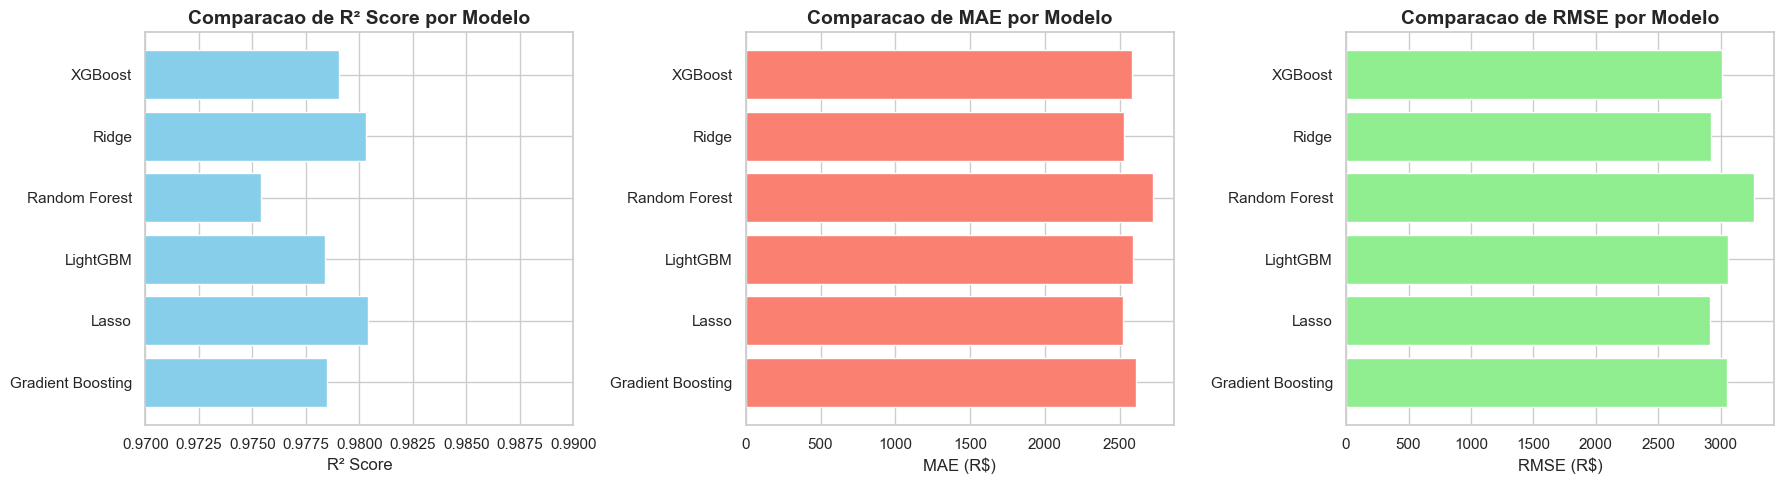

Grafico salvo em reports/figures/mlflow_comparacao_modelos.png


In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filtrar apenas os runs de GridSearch (excluir duplicatas)
runs_grid = runs[runs['tags.mlflow.runName'].str.contains('GridSearch', na=False)]

# Preparar dados para visualizacao
modelos_unicos = runs_grid.groupby('params.modelo_tipo').first().reset_index()

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Grafico 1: R² Score
axes[0].barh(modelos_unicos['params.modelo_tipo'], modelos_unicos['metrics.r2_score'], color='skyblue')
axes[0].set_xlabel('R² Score', fontsize=12)
axes[0].set_title('Comparacao de R² Score por Modelo', fontsize=14, fontweight='bold')
axes[0].set_xlim(0.97, 0.99)

# Grafico 2: MAE
axes[1].barh(modelos_unicos['params.modelo_tipo'], modelos_unicos['metrics.mae'], color='salmon')
axes[1].set_xlabel('MAE (R$)', fontsize=12)
axes[1].set_title('Comparacao de MAE por Modelo', fontsize=14, fontweight='bold')

# Grafico 3: RMSE
axes[2].barh(modelos_unicos['params.modelo_tipo'], modelos_unicos['metrics.rmse'], color='lightgreen')
axes[2].set_xlabel('RMSE (R$)', fontsize=12)
axes[2].set_title('Comparacao de RMSE por Modelo', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('../reports/figures/mlflow_comparacao_modelos.png', dpi=300, bbox_inches='tight')
plt.show()

print("Grafico salvo em reports/figures/mlflow_comparacao_modelos.png")